In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install mxnet
!pip install gluonnlp pandas tqdm
!pip install sentencepiece
!pip install transformers==3.0.2
!pip install torch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 49.1 MB 172 kB/s 
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 344 kB 28.5 MB/s 
  Created wheel for gluonnlp: filename=gluonnlp-0.10.0-cp37-cp37m-linux_x86_64.whl size=595723 sha256=121fe315f2166783529c06f95be41575d3f8ff51ba77be798c499ebc3e5a2d98
  Stored in directory: /root/.cache/pip/wheels/be/b4/06/7f3fdfaf707e6b5e98b79c041e023acffbe395d78a527eae00
Successfully built gluonnlp
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.2 MB 25.0 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.p

In [3]:
#깃허브에서 KoBERT 파일 로드
!pip install git+https://git@github.com/SKTBrain/KoBERT.git@master

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://****@github.com/SKTBrain/KoBERT.git (to revision master) to /tmp/pip-req-build-nel88l83
  Running command git clone -q 'https://****@github.com/SKTBrain/KoBERT.git' /tmp/pip-req-build-nel88l83
     |████████████████████████████████| 132 kB 30.2 MB/s 
     |████████████████████████████████| 4.5 MB 59.6 MB/s 
     |████████████████████████████████| 4.4 MB 59.6 MB/s 
     |████████████████████████████████| 101 kB 10.4 MB/s 
     |████████████████████████████████| 6.6 MB 40.6 MB/s 
     |████████████████████████████████| 596 kB 27.8 MB/s 
     |████████████████████████████████| 79 kB 4.8 MB/s 
     |████████████████████████████████| 8.9 MB 45.8 MB/s 
     |████████████████████████████████| 127 kB 61.4 MB/s 
  Created wheel for kobert: filename=kobert-0.2.3-py3-none-any.whl size=15674 sha256=45ab581e29ef1acb727a18a9fd21d4b157002f9af1a98b2716f882761f1d187d
  Stored in director

### 학습시킨 Kobert 모델을 불러온다.

In [4]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import gluonnlp as nlp
import numpy as np
from tqdm import tqdm, tqdm_notebook

#kobert
from kobert.utils import get_tokenizer
from kobert.pytorch_kobert import get_pytorch_kobert_model

#transformers
from transformers import AdamW
from transformers.optimization import get_cosine_schedule_with_warmup

In [5]:
class BERTDataset(Dataset):
    def __init__(self, dataset, sent_idx, label_idx, bert_tokenizer, max_len,
                 pad, pair):
        transform = nlp.data.BERTSentenceTransform(
            bert_tokenizer, max_seq_length=max_len, pad=pad, pair=pair)

        self.sentences = [transform([i[sent_idx]]) for i in dataset]
        self.labels = [np.int32(i[label_idx]) for i in dataset]

    def __getitem__(self, i):
        return (self.sentences[i] + (self.labels[i], ))

    def __len__(self):
        return (len(self.labels))



In [6]:
# Setting parameters
max_len = 64
batch_size = 64
warmup_ratio = 0.1
num_epochs = 10
max_grad_norm = 1
log_interval = 200
learning_rate =  5e-5

#GPU 사용
device = torch.device("cuda:0")

In [7]:
class BERTClassifier(nn.Module):
    def __init__(self,
                 bert,
                 hidden_size = 768,
                 num_classes=4,   ##클래스 수 조정##
                 dr_rate=None,
                 params=None):
        super(BERTClassifier, self).__init__()
        self.bert = bert
        self.dr_rate = dr_rate
                 
        self.classifier = nn.Linear(hidden_size , num_classes)
        if dr_rate:
            self.dropout = nn.Dropout(p=dr_rate)
    
    def gen_attention_mask(self, token_ids, valid_length):
        attention_mask = torch.zeros_like(token_ids)
        for i, v in enumerate(valid_length):
            attention_mask[i][:v] = 1
        return attention_mask.float()

    def forward(self, token_ids, valid_length, segment_ids):
        attention_mask = self.gen_attention_mask(token_ids, valid_length)
        
        _, pooler = self.bert(input_ids = token_ids, token_type_ids = segment_ids.long(), attention_mask = attention_mask.float().to(token_ids.device))
        if self.dr_rate:
            out = self.dropout(pooler)
        return self.classifier(out)

In [8]:
model = torch.load('/content/drive/MyDrive/감성분석_boaz/KoBERT_담화.pt')  # 전체 모델을 통째로 불러옴, 클래스 선언 필수
model.load_state_dict(torch.load('/content/drive/MyDrive/감성분석_boaz/model_state_dict.pt'))  # state_dict를 불러 온 후, 모델에 저장

<All keys matched successfully>

In [9]:
bertmodel, vocab = get_pytorch_kobert_model()

tokenizer = get_tokenizer()
tok = nlp.data.BERTSPTokenizer(tokenizer, vocab, lower=False)

def predict(predict_sentence):

    data = [predict_sentence, '0']
    dataset_another = [data]

    another_test = BERTDataset(dataset_another, 0, 1, tok, max_len, True, False)
    test_dataloader = torch.utils.data.DataLoader(another_test, batch_size=batch_size, num_workers=5)
    
    model.eval()

    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(test_dataloader):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)

        valid_length= valid_length
        label = label.long().to(device)

        out = model(token_ids, valid_length, segment_ids)


        test_eval=[]
        for i in out:
            logits=i
            logits = logits.detach().cpu().numpy()

            if np.argmax(logits) == 0:
                test_eval.append("분노")
            elif np.argmax(logits) == 1:
                test_eval.append("슬픔")
            elif np.argmax(logits) == 2:
                test_eval.append("중립")
            elif np.argmax(logits) == 3:
                test_eval.append("행복")

        return(test_eval[0])

/content/.cache/kobert_v1.zip[██████████████████████████████████████████████████]
/content/.cache/kobert_news_wiki_ko_cased-1087f8699e.spiece[██████████████████████████████████████████████████]
using cached model. /content/.cache/kobert_news_wiki_ko_cased-1087f8699e.spiece


카카오톡 데이터 불러오기

In [10]:
import re
import pandas as pd
import os 
import matplotlib.pyplot as plt

In [11]:
def katalk_msg_parse(file_path):
    my_katalk_data = list()
    katalk_msg_pattern = "[0-9]{4}[년.] [0-9]{1,2}[월.] [0-9]{1,2}[일.] 오\S [0-9]{1,2}:[0-9]{1,2},.*:"
    date_info = "[0-9]{4}년 [0-9]{1,2}월 [0-9]{1,2}일 \S요일"
    in_out_info = "[0-9]{4}[년.] [0-9]{1,2}[월.] [0-9]{1,2}[일.] 오\S [0-9]{1,2}:[0-9]{1,2}:.*"

    for line in open(file_path,'rt', encoding='UTF8'):
        if re.match(date_info, line) or re.match(in_out_info, line):
            continue
        elif line == '\n':
            continue
        elif re.match(katalk_msg_pattern, line):
            line = line.split(",")
            date_time = line[0]
            user_text = line[1].split(" : ", maxsplit=1)
            user_name = user_text[0].strip()
            text = user_text[1].strip()
            my_katalk_data.append({'date_time': date_time,
                                   'user_name': user_name,
                                   'text': text
                                   })

        else:
            if len(my_katalk_data) > 0:
                my_katalk_data[-1]['text'] += "\n"+line.strip()

    my_katalk_df = pd.DataFrame(my_katalk_data)

    return my_katalk_df

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


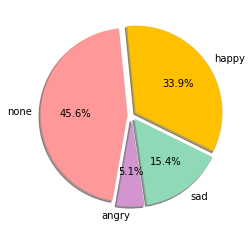

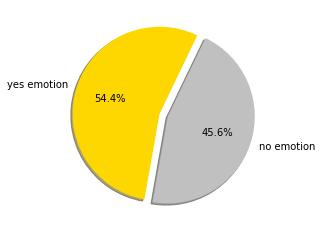

In [13]:
# def chat_SA(파일경로,파일이름):
파일경로= '/content/drive/MyDrive/감성분석_boaz/' # 파일이 저장되어 있는 경로
파일이름= 'Talk_2022.6.28 11_29-1.txt' # 카톡 대화내보내기 파일 이름

df = katalk_msg_parse(os.path.join(파일경로, 파일이름))

# 채팅방 감정 추출
emotion_list=[]
emotion_list.append(df.text.apply(lambda x : predict(x)))


emotion_df=pd.DataFrame()
for i in range(len(emotion_list[0])) :
  emotion_df=emotion_df.append([emotion_list[0][i]])
emotion_df.columns=["감정"]
emotion_df.reset_index(drop=True,inplace=True)

#감정 분포 시각화
emotion_ratio=pd.DataFrame({'비율' :emotion_df.value_counts()})
emotion_ratio=emotion_ratio.비율/(emotion_ratio.비율.sum())
emotion_ratio2=pd.DataFrame(emotion_ratio)
explode = [0.05, 0.05, 0.05, 0.05]
colors = ['#ff9999', '#ffc000', '#8fd9b6', '#d395d0']
plt.pie(emotion_ratio2.비율.to_list(), labels=['none','happy','sad','angry'], autopct='%.1f%%',colors=colors, startangle=260, counterclock=False, explode=explode, shadow=True)
plt.show()


# #감정의 유무 분포 시각화
yes_no_ratio=pd.DataFrame( [emotion_ratio[['행복','분노','슬픔']].sum(),emotion_ratio['중립']] , index=['감정적인 대화','감정없는 대화'],columns=['비율']) 
explode = [0.05, 0.05]
colors = [ 'gold','silver']
plt.pie(yes_no_ratio.비율.to_list(), labels=['yes emotion','no emotion'], autopct='%.1f%%',colors=colors, startangle=260, counterclock=False, explode=explode, shadow=True)
plt.show()

In [ ]:
#궁금한 문장 찾기 
final_data=pd.concat([df,emotion_df],axis=1)

sentence = 1
while sentence != 'End' :
    sentence = input("문장 찾기 : ")
    
    if sentence == 'End' :
        break
    
    print(final_data.text[final_data.감정==sentence])
    print("\n")

# 추천 결과

In [14]:
music_df=pd.read_csv('/content/drive/MyDrive/감성분석_boaz/감정matrix포함_노래.csv')

In [15]:
#중립 뺀 감정
chat_emotion=pd.DataFrame(emotion_ratio) ; chat_emotion
chat_emotion.drop(index='중립',inplace=True)
chat_emotion=chat_emotion/chat_emotion.비율.sum()
chat_emotion=chat_emotion.transpose()


/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:4150: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


In [16]:
#채팅방 감성 비율 재구성 ( happy, sad, angry)
chat=np.array(chat_emotion);chat

array([[0.62340967, 0.28244275, 0.09414758]])

In [17]:
#음악 감성 matrix
music_matrix=music_df[['happy','sad','angry']]
music=np.array(music_matrix) ;music

array([[0.59459459, 0.40540541, 0.        ],
       [0.68      , 0.32      , 0.        ],
       [0.59322034, 0.38983051, 0.01694915],
       ...,
       [0.46153846, 0.53846154, 0.        ],
       [0.71428571, 0.28571429, 0.        ],
       [0.69230769, 0.30769231, 0.        ]])

In [18]:
from scipy.spatial.distance import cosine
#코사인 유사도 구하기

cosine_lst=[]
for i in range(len(music)) :
  cosine_lst.append(1 - cosine(chat, music[i]))


In [19]:
#상위 n개 리스트 index 가져오기
n=10
lst_index=sorted(range(len(cosine_lst)), key=lambda i: cosine_lst[i])[-n:]
lst_index.reverse() 
music_df.loc[lst_index,['song_name','artist']] 

,song_name,artist
718,MOVIE,비투비
908,어떻게 지내 (Prod. By VAN.C),오반
453,Good Luck,비스트
81,U,포맨 (4MEN)
949,마음이 말하는 행복 (Happiness) (Feat.이라온),마크툽 (MAKTUB)
150,처음 사랑하는 연인들을 위해 (반말송),정용화 (CNBLUE)
898,시작,가호 (Gaho)
138,내꺼중에 최고,이현
715,She's a Baby,지코 (ZICO)
736,Way Back Home,숀 (SHAUN)


#### PPT자료에 쓰인 결과와 다르게 나온 이유?  
LSTM모델을 돌릴 때 randon,set_seed를 지정해주지 않았어서 다시돌리니 결과가 달라짐!
